# Results 

### Analysis of the final data set  

After the loading, merging, and pre-processing of our 3 datasets, we have the final `final_merged_data.csv` dataset composed of:

|                           | Movie name           | Movie release date | Movie box office revenue | Movie runtime | Movie languages | Movie countries | Movie genres | Movie score | Movie votes | Movie director | Movie star | Movie budget | Movie gross | Movie company | Number of nominations | Nomination winner | Budget/revenues ratio |
|---------------------------|----------------------|---------------------|--------------------------|---------------|-----------------|-----------------|--------------|-------------|-------------|-----------------|------------|--------------|-------------|---------------|-----------------------|-------------------|-----------------------|
| **Type of values**        | Str                  | Int                | Float                    | Int           | Str             | Str             | Str          | Float       | Int         | Str             | Str        | Float        | Float       | Str           | Int                   | Int               | Float                 |
| **Example**               | midnight_in_paris	       | 2011              | 151119219.0               | 100.0           | French Language          | United States of America, Spain      | Romantic comedy, Romance Film        | 7.7         | 398000.0      | Woody Allen | Owen Wilson | 17000000.0   | 151653750.0	  | Mediapro	 | 1.0                     | Dianne Wiest	               | 8.889366                |
| **Number of rows with info** |  81741               | 74839                 |  8401                       | 61291            | 81741              | 73587              | 79447          | 5605          | 5605          | 5605              | 5605        | 4148           | 5496          | 5596            | 1011                    | 297                | 3537                    |


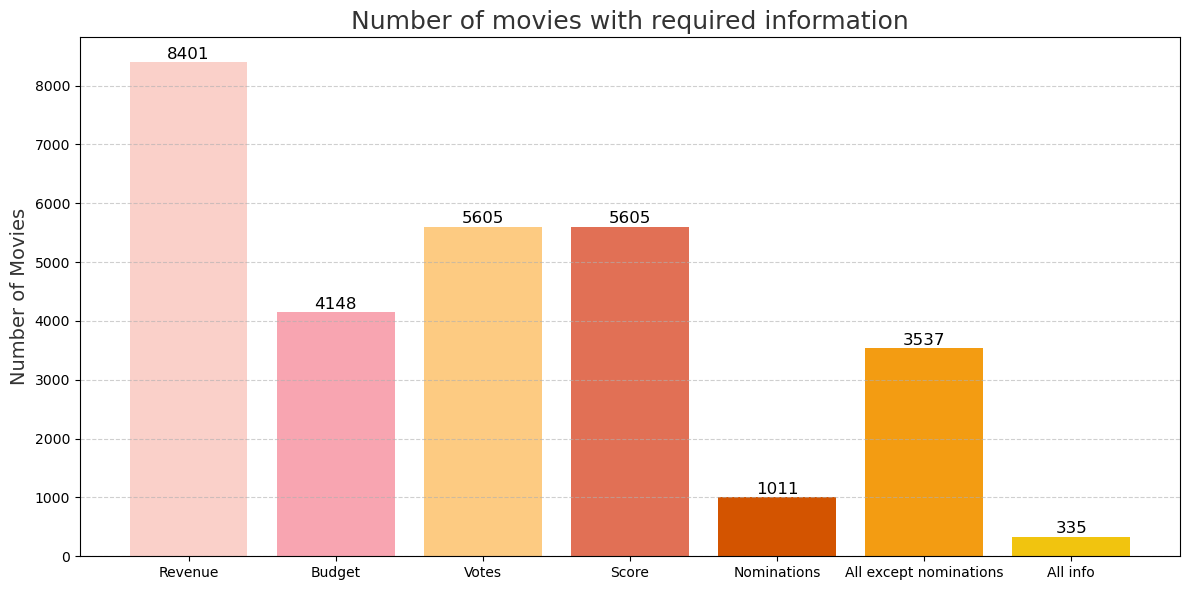

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/final_merged_data.csv')
df.columns

n_revenue = int(df['Movie box office revenue'].count())
n_budget = int(df['Movie budget'].count())
n_votes = int(df['Movie votes'].count())
n_score = int(df['Movie score'].count())
n_nomination = int(df['Number of nomination'].count())


n_all_info = int(df.dropna(subset=['Movie box office revenue', 'Movie budget', 'Movie votes', 'Movie score', 'Number of nomination']).shape[0])
n_no_nomin = int(df.dropna(subset=['Movie box office revenue', 'Movie budget', 'Movie votes', 'Movie score']).shape[0])

labels = ['Revenue', 'Budget', 'Votes', 'Score', 'Nominations', 'All except nominations', 'All info']
values = [n_revenue, n_budget, n_votes, n_score, n_nomination, n_no_nomin, n_all_info]


plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=['#FAD0C9', '#F8A5B1', '#FDCB82', '#E17055', '#D35400', '#F39C12', '#F1C40F'])


plt.title('Number of movies with required information', fontsize=18, fontweight='normal', color='#333333')  # Indigo color
plt.ylabel('Number of Movies', fontsize=14, color='#333333')  # Dark gray for axis label
plt.grid(axis='y', linestyle='--', alpha=0.6)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom', fontsize=12)


plt.tight_layout()
plt.show()

To establish the success of our index, we are focused on specific criteria such as budget, revenues, ratings, number of nominations, and the budget-to-revenue ratio. Our goal is to assess whether we have enough reliable data to effectively study these factors. We analyzed the available data and determined that the original CUM Movie dataset contains 8 401 movies, with revenue data as the minimum required for our project. From the additional dataset, we identified 5 119 movies that meet other key criteria, including budget, votes, and score, which represents about 64% of the original dataset. Given this sample size, we are confident that we have sufficient and reliable data to move forward with constructing the success index. The next step will be to normalize and properly weight each criterion to build the index.

## Sucess index set up  